In [3]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import math
import dlib
import sys
from scipy.spatial import distance
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image, ImageDraw
sys.path.append("/work/Particle_Filter/circle_finder_main/circle_finder_main")
from circle_finder.csf import CircularSeparabilityFilter
from circle_finder.torch import EllipticalSeparabilityFilter
sys.path.append("/work/Particle_Filter")
from particle_fileter_main.test_1 import ParticleFilter
from contour_extraction.test_0 import clac_contour_iris
from contour_extraction.test_1 import Contour_Iris
from Siamese_Network.test_5 import Eye_open_rate
from imutils import face_utils
import time
#楕円形分離度フィルタ
def a(img,a,b,c,d):
    axes_in = a,b
    axes_out = c,d
    angle = 0
    esf = EllipticalSeparabilityFilter(axes_in,axes_out,angle)
    epmap,circles = esf.find_circles(img, num_circles=5)   #num_circlesの適切値は？？
    cut_img = esf.cut_img_4(img,circles)     #カットできない画像は黒画像が返される
    rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return epmap,cut_img,circles
#中心座標を用いて、指定サイズにトリミング
def cut_img(img,center,size):
    x = int(size[0]/2)
    y = int(size[1]/2)
    a= int(center[0])
    b= int(center[1])
    data = img[b-y:b+y,a-x:a+x]
    return data
#開眼度計算、可変閾値処理
def calc_ratio(img,radius):
    center = int(img.shape[0]/2),int(img.shape[1]/2)
    eor=Eye_open_rate(img,radius,center)
    img_2 = eor.cut_img()
    #print(f"定量評価の２値化画像サイズ：{img_2.shape}")
    blackAreaRatio = eor.calc_blackArea(img_2)
    return blackAreaRatio,img_2
#虹彩の中心座標と虹彩半径の計算
def eye_center(eye):
    A = (eye[1]+eye[4])
    B = (eye[2]+eye[5])
    center = (A + B) / 4
    C = distance.euclidean(eye[1],eye[4])
    D = distance.euclidean(eye[2],eye[5])
    radius = (C + D ) / 4   #目をつぶったとき分離度マップはどうなる？？
    return center,radius
#右目ランドマークのプロット
def plot_landmark(numpy_img,landmark):
    for index,(x,y) in enumerate(landmark,start=36):
        x = landmark[index][0]
        y = landmark[index][1]
        if(index==42):break
        else:cv.circle(numpy_img, (x, y), 5, (255, 255, 0), -1)
    return numpy_img
#トリミングするサイズの計算
def calc_size(eye):
    A = distance.euclidean(eye[0], eye[3])*2
    B = distance.euclidean(eye[1], eye[4])
    C = distance.euclidean(eye[2], eye[5])
    D = (B + C)
    size = (int(A),int(D))
    return size

In [4]:
def tracking():
    start = time.time()
    #初期設定
    path = "/work/Particle_Filter/Siamese_Network/video/Bright_40cm.mp4"
    cap = cv.VideoCapture(path)
    size = (1080,1920) #元画像のサイズ
    filter_eye_left = ParticleFilter(size)
    filter_eye_left.initialize() #パーティクルフィルタ初期化    
    x,y,z = 0,0,0
    flag = True
    img_left,img_right,img_3,img_4,img_5,img_6,img_7,eye_left_opening_rate = [],[],[],[],[],[],[],[]
    alpha,beta = 0,0
    threshold = 0   #得たいフレームの開始番号    
    face_detector = dlib.get_frontal_face_detector()    # 顔検出ツールの呼び出し
    predictor_path = '/work/Particle_Filter/particle_fileter_main/shape_predictor_68_face_landmarks.dat'
    face_predictor = dlib.shape_predictor(predictor_path)
    #各フレームに対して虹彩の輪郭を求める
    while flag:
        if x<threshold:
            ret, img_1 = cap.read()
            x+=1
        if x>threshold or x ==threshold:
            ret, img_1 = cap.read()   
            if x%50==0:
                print(str(x)+"枚目の画像の追跡")
            #print(str(x)+"枚目の画像の追跡") 
            x+=1
            #ランドマークの抽出
            if(cap.isOpened()==True and img_1 is not None):#Trueが返されたら動画読み込みOK
                test_img = img_1.copy()#引数用
                draw_img = img_1.copy()#描画用
                img_gry = cv.cvtColor(test_img, cv.COLOR_BGR2GRAY)
                faces = face_detector(img_gry, 1)
                for face in faces:#検出した顔の数だけfor文を回す
                    landmark = face_predictor(img_gry, face)
                    landmark = face_utils.shape_to_np(landmark)# 処理高速化のためランドマーク群をNumPy配列に変換(必須)     
                    center,radius = eye_center(landmark[36:42])#虹彩の中心と分離度フィルタの半径を得る
                    size = calc_size(landmark[36:42]) #ここでトリミングするサイズが決まる！！
                    width,height =  size[0],size[1]
                    x_before,y_before = size[0]/2,size[1]/2
                    #draw_img =  plot_landmark(draw_img,landmark)#左目のランドマークをplot
                    #print(f"size:{size}/radius:{radius}/center:{center}/")
            else:
                x+=1
                continue
                
            #ランドマークの判別処理
            if (landmark is not None):
                center_eye_left = center[0],center[1]#全体の状態での座標
                center_eye_left_x,center_eye_left_y = center[0],center[1]
            else:
                center_eye_left = [center_eye_left_x,center_eye_left_y]#radiusは1フレーム前のものを採用する
                
            #虹彩の中心座標を求める
            img_eye_left = cut_img(test_img,center_eye_left,size)#左の瞳付近をトリミング
            #print(img_eye_left.shape)
            
            y_after, x_after = filter_eye_left.filtering(img_eye_left, radius, width,height)#瞳の中心座標の推定値を取得
            #print(f"x_after:{x_after} , y_after:{y_after}")
            
            alpha,beta = x_after - x_before , y_after - y_before
            #beta = y_after - y_before
            center_eye_left_x,center_eye_left_y = center_eye_left_x+alpha , center_eye_left_y+beta
            #center_eye_left_y = center_eye_left_y+beta
            center_eye_left = [center_eye_left_x,center_eye_left_y]
            img_eye_left = cut_img(test_img,center_eye_left,size)#左の瞳付近を再トリミング
            img_eye_left = cv.cvtColor(img_eye_left, cv.COLOR_BGR2RGB)
            #print(f"定量評価の元画像サイズ：{img_eye_left.shape}")
            
            #ratio = calc_ratio(x_after,y_after,img_eye_left,radius)
            ratio,binary = calc_ratio(img_eye_left,radius)#開眼度と2値化画像を取得
            
            #全体画像に対して虹彩の中心座標をプロット
            alpha = x_after - x_before
            beta = y_after - y_before
            center_eye_left_x_1 = center_eye_left_x+alpha
            center_eye_left_y_1 = center_eye_left_y+beta
            cv.circle(draw_img,center=(int(center_eye_left_x_1), int(center_eye_left_y_1)),radius=3,color=(0, 0, 255),thickness=-1)
            draw_img = cv.cvtColor(draw_img, cv.COLOR_BGR2RGB)
            
            #出力準備
            img_3.append(draw_img)
            img_4.append(img_eye_left)
            img_5.append(binary)
            img_6.append(radius)
            img_7.append(test_img)
            eye_left_opening_rate.append(ratio)
            
        if x > 600:#目を閉じた後しっかり追跡できるか
            elapsed_time = time.time() - start
            print (f"elapsed_time:{round(elapsed_time,3)}[sec]")
            print("追跡を終了します")
            flag = False

    return img_3,img_4,img_5,img_6,img_7,eye_left_opening_rate

In [5]:
img,img_2,img_3,radius,origin,ratio = tracking()

0枚目の画像の追跡
50枚目の画像の追跡
100枚目の画像の追跡
150枚目の画像の追跡
200枚目の画像の追跡
250枚目の画像の追跡
300枚目の画像の追跡
350枚目の画像の追跡
400枚目の画像の追跡
450枚目の画像の追跡
500枚目の画像の追跡
550枚目の画像の追跡
600枚目の画像の追跡
elapsed_time:760.866[sec]
追跡を終了します


ratio:0.766 , radius:21.527676372585283


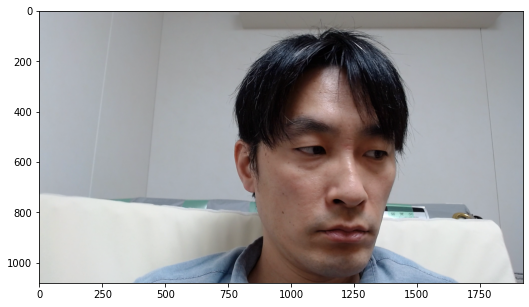

In [6]:
x=10
plt.figure(figsize=(10,5))
print(f"ratio:{ratio[x]} , radius:{radius[x]}")
ori = cv.cvtColor(origin[x], cv.COLOR_BGR2RGB)
plt.imshow(ori)

radius[10]:12.695432059723533 , ratio[10]:0.748
追跡元画像サイズ：(1080, 1920, 3)
虹彩周辺画像サイズ：(50, 116, 3)
2値化画像サイズ：(49, 115)


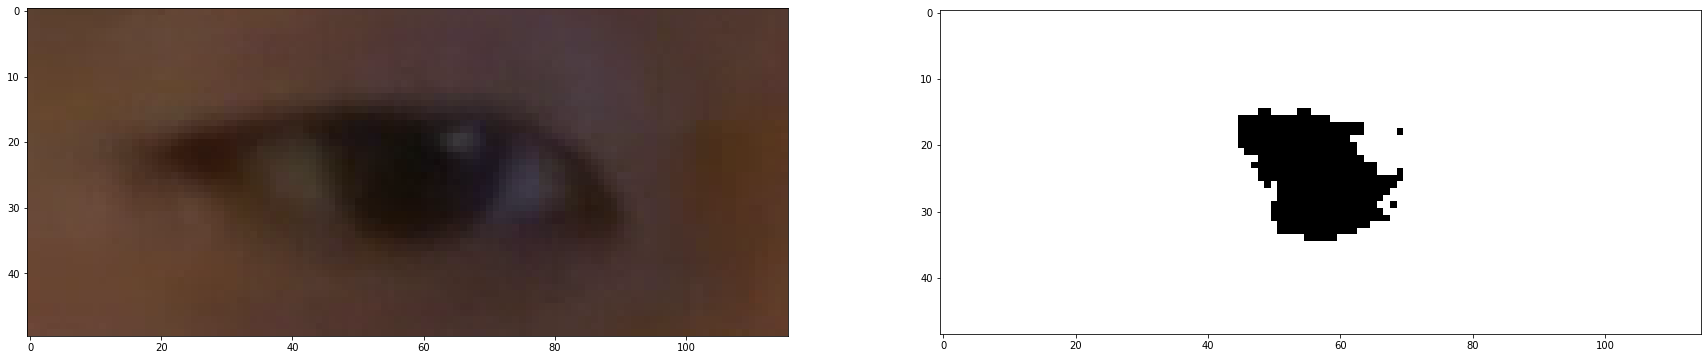

In [5]:
x = 10
print(f"radius[{x}]:{radius[x]} , ratio[{x}]:{ratio[x]}")
print(f"追跡元画像サイズ：{img[x].shape}")
print(f"虹彩周辺画像サイズ：{img_2[x].shape}")
print(f"2値化画像サイズ：{img_3[x].shape}")
plt.figure(figsize=(30,20))
plt.subplot(1,2,1)
plt.imshow(img_2[x])
plt.subplot(1,2,2)
plt.imshow(img_3[x],cmap="gray")

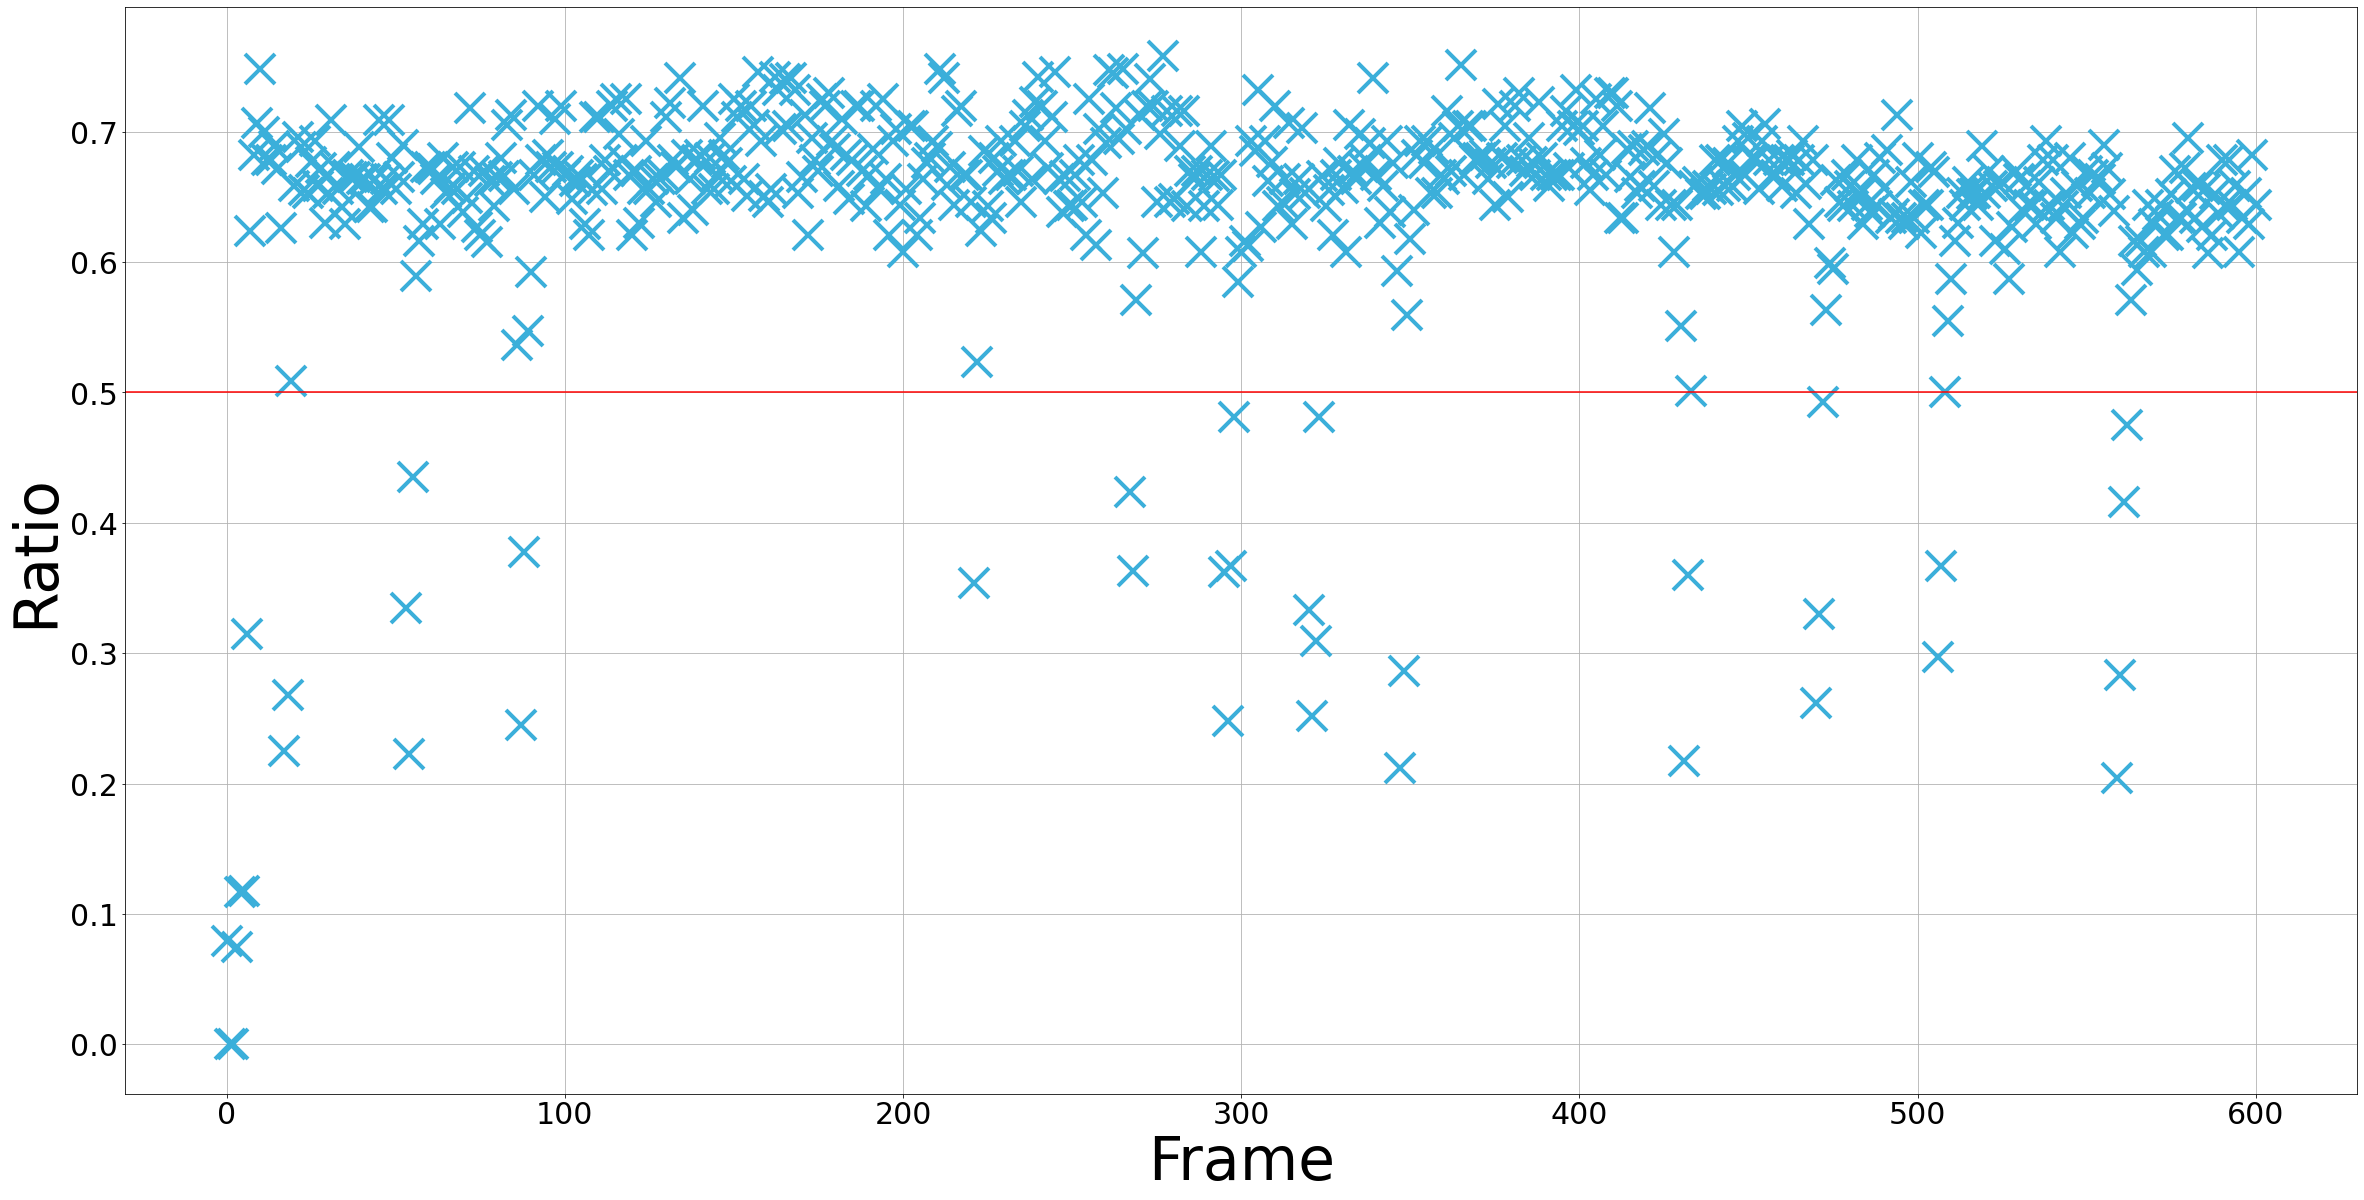

In [6]:
import pandas as pd

num = len(img)#開眼度のグラフを表示
x_1 = np.arange(num)
y_1 = np.array(ratio)
threshold = 0.5
z = (y_1<threshold)
#z = (y_1>threshold)
x_2 = np.where(z)#threshold未満を満たすインデックス
#print(x_2)

fig = plt.figure(figsize=(40,20))
#plt.plot(x_1,y_1) 
plt.plot(x_1,y_1,color="#3bafda",marker="x",markersize=30,markeredgewidth=4,linewidth=3,linestyle="None") 

plt.xlabel("Frame" ,fontsize = 60)
plt.ylabel("Ratio" ,fontsize = 60)
plt.tick_params(labelsize=30)
plt.grid()

plt.axhline(y=threshold,color='r')
plt.show()

In [7]:
print(len(x_2[0]))
print(x_2[0])

38
[  0   1   2   3   4   5   6  17  18  53  54  55  87  88 221 267 268 295
 296 297 298 320 321 322 323 347 348 431 432 470 471 472 506 507 559 560
 561 562]


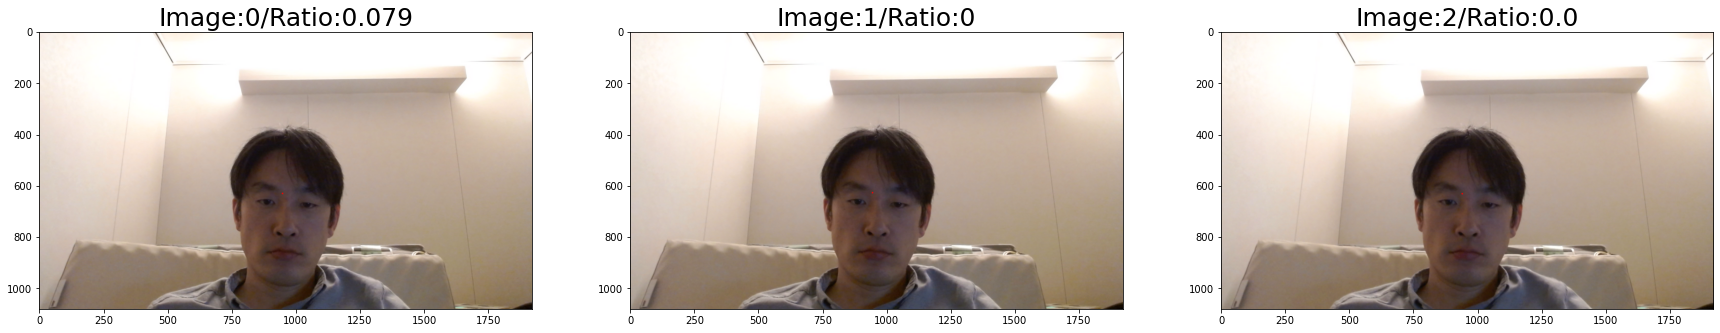

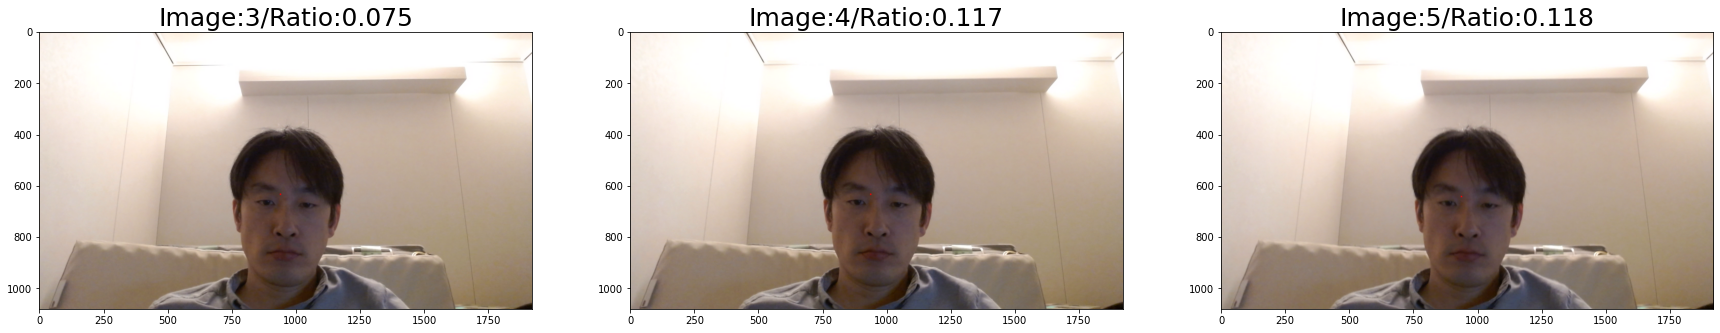

In [8]:
num = len(x_2[0])#開眼度の低い画像を表示,追跡元画像
x=0
width = 3
# height = int(num/width)
height = 2
for m in range(height):
    plt.figure(figsize=(30,20))
    for n in range(width):
        index=n%width+1
        plt.subplot(1,3,index)
        plt.title("Image:"+str(x_2[0][x])+"/Ratio:"+str(ratio[x_2[0][x]]),fontsize=25)
        plt.imshow(img[x_2[0][x]])
        x+=1

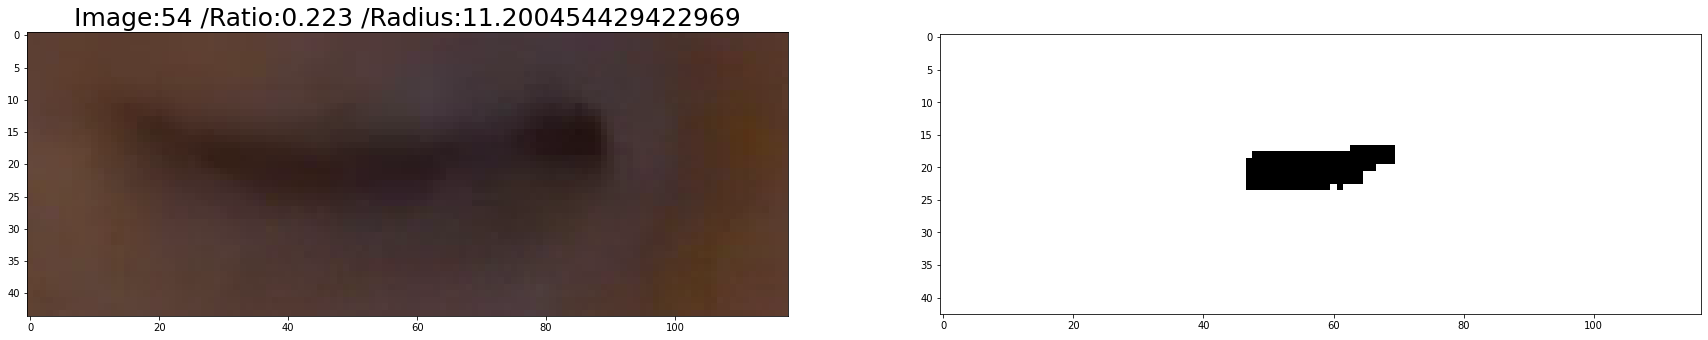

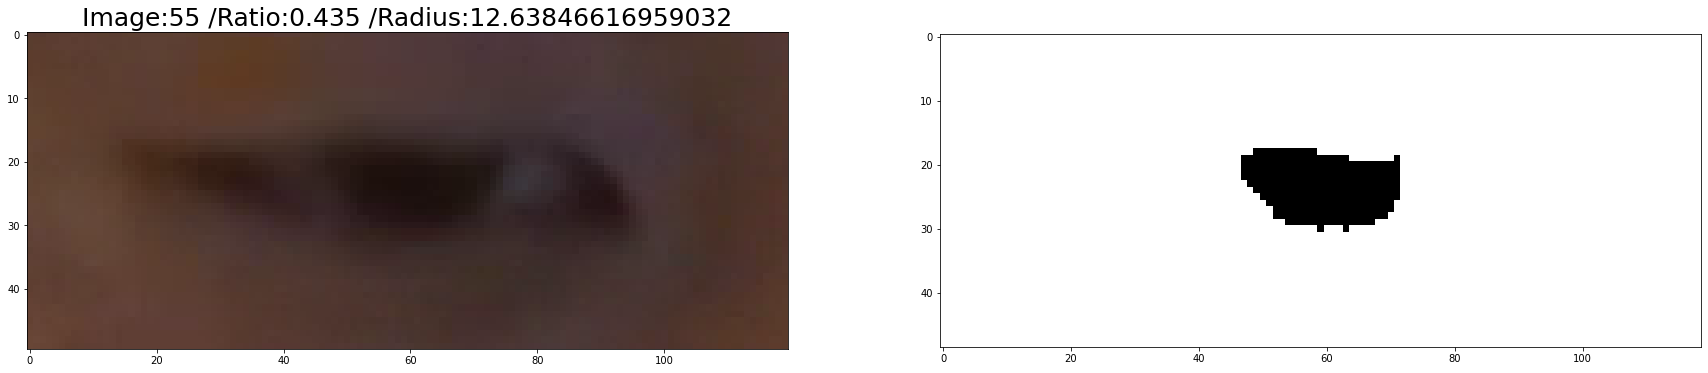

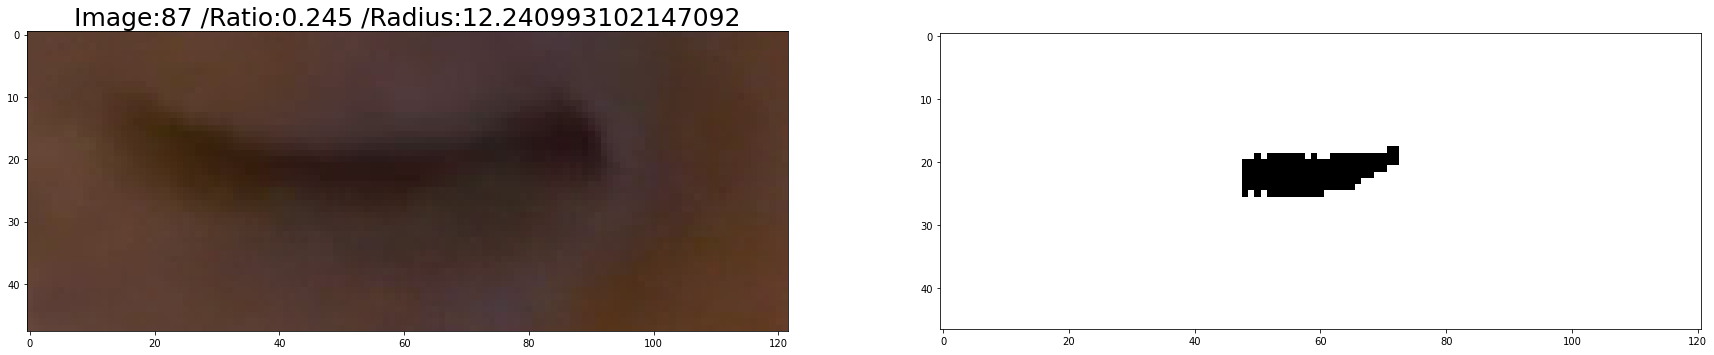

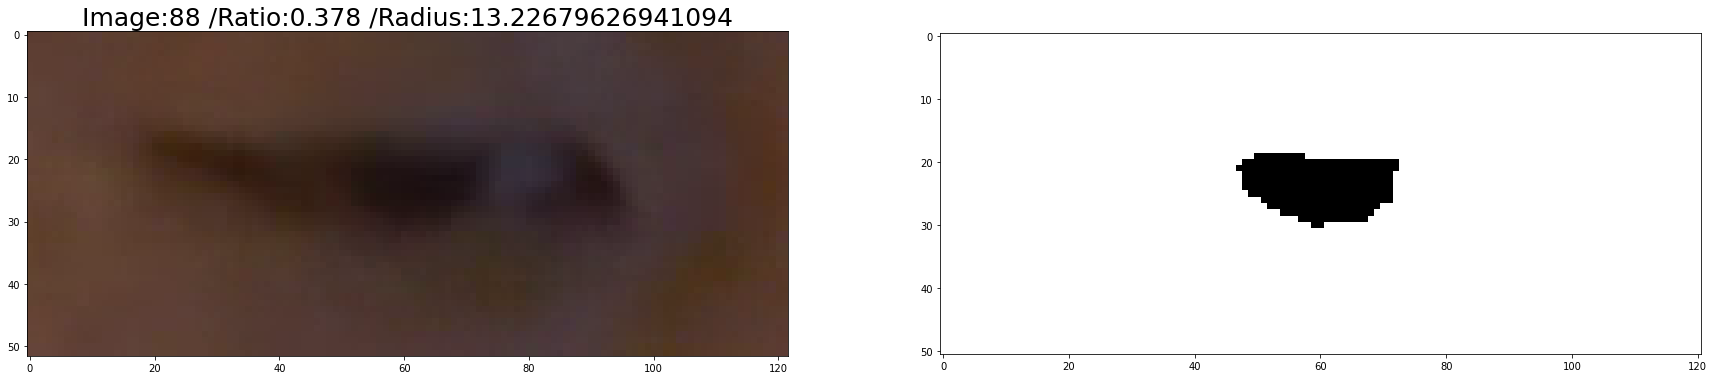

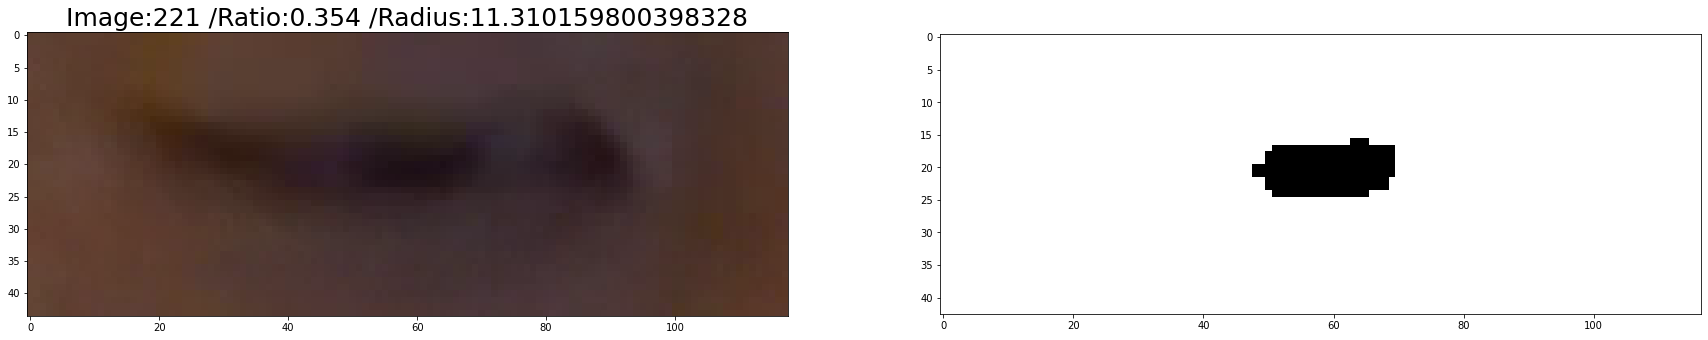

In [10]:
num = len(img_2[0])#開眼度の低い画像を表示,IrisとBinary
x=10
width = 2
# height = int(num/width)
height = 5
for m in range(height):
    plt.figure(figsize=(30,20))
    index=1
    plt.subplot(1,width,index)
    plt.title("Image:"+str(x_2[0][x])+" /Ratio:"+str(ratio[x_2[0][x]])+" /Radius:"+str(radius[x_2[0][x]]),fontsize=25)
    plt.imshow(img_2[x_2[0][x]])
    plt.subplot(1,width,index+1)
    plt.imshow(img_3[x_2[0][x]],cmap="gray")
    x+=1

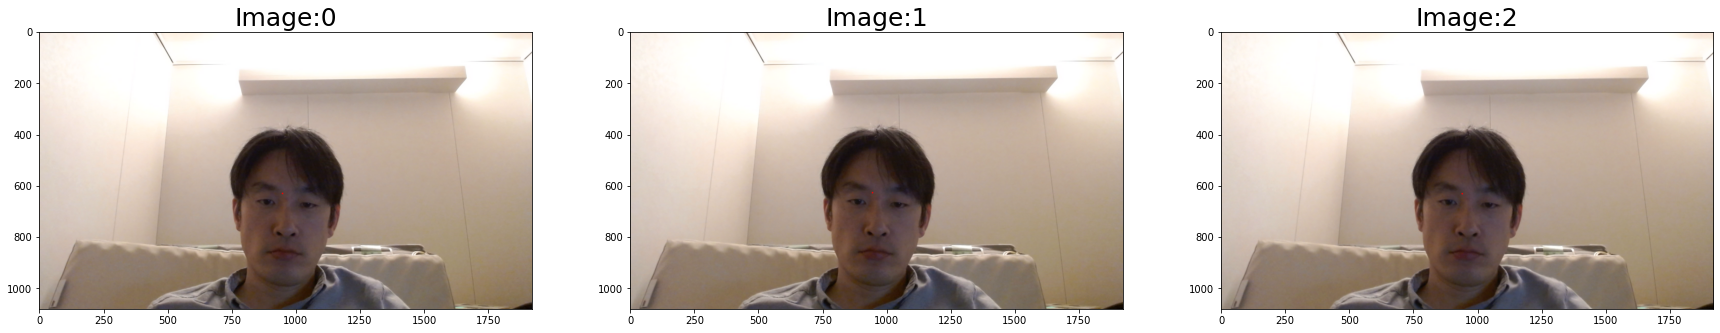

In [11]:
## 画像の表示
num = len(img)#画像と開眼度を表示
x= 0
width = 3
height = 1
for m in range(height):
    plt.figure(figsize=(30,20))
    for n in range(width):
        index=n%width+1
        plt.subplot(1,width,index)
        plt.title("Image:"+str(x),fontsize=25)
        plt.imshow(img[x])
        x+=1

In [ ]:
#    ここから保存！！！     #

In [12]:
name = "Dim_60cm"
method = "Variable"

In [13]:
#グラフ保存
fig.savefig("/work/Particle_Filter/Experiment/" + name + "/" + method + "/Figure/" + method + ".png")
#リスト保存
import pickle
f = open("/work/Particle_Filter/Experiment/" + name + "/" + method + "/Ratio/" + method + ".txt", 'wb')
list_row = ratio
pickle.dump(list_row, f)

In [14]:
#虹彩画像保存
for i in range(len(img)):
    iris = cv.cvtColor(img_2[i], cv.COLOR_BGR2RGB)
    cv.imwrite("/work/Particle_Filter/Experiment/" + name + "/" + method + "/Binary/"+str(i)+".png", img_3[i])
    cv.imwrite("/work/Particle_Filter/Experiment/" + name + "/" + method + "/Iris/"+str(i)+".png", iris)
    cv.imwrite("/work/Particle_Filter/Experiment/" + name + "/" + method + "/Origin/"+str(i)+".png",origin[i])

In [15]:
#動画保存
import os
import cv2 as cv
import numpy as np
num = len(img)#フィルタの数
x=0
# 画像サイズ
h = img[0].shape[0]
w = img[0].shape[1]
img_outdir = "/work/Particle_Filter/Experiment/Video/" + method +"/"
os.makedirs(img_outdir, exist_ok=True)
# 動画用の画像
outimg_files = img
# 動画作成
fourcc = cv.VideoWriter_fourcc(*'XVID')
video  = cv.VideoWriter(img_outdir + name + '_0.avi', fourcc, 20.0, (w, h), True)
for x in range(num):
    img_video = outimg_files[x]
    img_video = cv.cvtColor(img_video, cv.COLOR_BGR2RGB)
    video.write(img_video)
video.release()